Script for generating Figure 4:
- Fig. 4:(a) Circumpolar classification of cross-slope profiles into Fresh (green), Cool (blue), Warm (red), and Dense (purple) categories described in the main text, indicated with four colorbars corresponding to the \citet{Thompson2018} characterisation based on observations (`Obs'), and ACCESS-OM2-01 output from the control, MW45, and MW85 simulations. Model output is classified by inspecting transects of potential density and temperature crossing the 1000 m isobath, averaged over the final year of the experimental period. The control pattern does not drift over the 10 year experimental period. 74 transects, taken at intervals of 5$^\circ$ longitude, are used, with additional transects included along the western edge of the Weddell Sea where the 1000 m isobath bears north. Maps show upper 1000 m depth mean absolute salinity anomalies averaged over the final year of the experiment. Black contours are the 1000 m isobath. (b) Example transects from the control simulation illustrating the four shelf break regimes used in (a) are shown. Transect locations are indicated in (a) by corresponding colored bars.

categorisation is based on a large quantity of cross isobath transects which are archived. 
This is just the figure creation, not the analysis itself.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as col
import matplotlib.path as mpath
### establish link to python functions
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
### import required python functions
from masking import shelf_mask_isobath
from spatial_averaging import month_weights
import cosima_cookbook as cc
from gsw import SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('text', usetex=True)
rc('xtick', labelsize=35) 
rc('ytick', labelsize=35) 
rc('axes', labelsize=35) 
from dask.distributed import Client
client = Client('tcp://localhost:8786')
import cmocean.cm as cmo
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
client

<Client: 'tcp://10.0.64.15:8786' processes=6 threads=6, memory=18.00 GB>

In [2]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)

In [3]:
control='01deg_jra55v13_ryf8485_spinup6'
rcp45='01deg_jra55v13_ryf8485_freshRCP45'
rcp85='01deg_jra55v13_ryf8485_freshRCP85'

In [4]:
## data required for lat/lon mapping and bathymetry contours
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

Plot ASF categorisation in strips to be positioned above salinity map.

In [5]:
def ASC_strips(ax1, ax2, ax3, ax4):
    
    ## strip dimensions are determined by eye based off transects of annual average temperature at 
    ## the regions indicated by the bars in the map.
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)
    plt.subplots_adjust(hspace=.1)

    ## THOMPSON et al 2018 COMPARISON (estimated from Figure 4)
    ## D regions
    ax1.fill_between([-29,-54],[0,0],[1,1], color = 'blueviolet')
    ax1.fill_between([-178,-228],[0,0],[1,1], color = 'blueviolet')
    ax1.fill_between([70,45],[0,0],[1,1], color = 'blueviolet')
    ## F regions
    ax1.fill_between([-54,-56],[0,0],[1,1], color = 'lightgreen')
    ax1.fill_between([-120,-178],[0,0],[1,1], color = 'lightgreen')
    ax1.fill_between([-228,-247],[0,0],[1,1], color = 'lightgreen')
    ax1.fill_between([-280,-258],[0,0],[1,1], color = 'lightgreen')
    ax1.fill_between([70,80],[0,0],[1,1], color = 'lightgreen')
    ax1.fill_between([-29,45],[0,0],[1,1], color = 'lightgreen')
    ## W regions
    ax1.fill_between([-120,-56],[0,0],[1,1], color = 'tomato')
    ax1.fill_between([-247,-258],[0,0],[1,1], color = 'tomato')
    ax1.axis('off')
    ax1.text(81,0.65, 'Obs', fontsize = 40)

    
    ## CONTROL PERIOD
    ax2.fill_between([52.5,80],[0,0],[1,1], color = 'blueviolet')
    ax2.fill_between([-32.5,52.5],[0,0],[1,1], color = 'lightgreen')
    ax2.fill_between([-62.5,-32.5],[0,0],[1,1], color = 'blueviolet')
    ax2.fill_between([-157.5,-62.5],[0,0],[1,1], color = 'tomato')
    ax2.fill_between([-177.5,-157.5],[0,0],[1,1], color = 'c')
    ax2.fill_between([-242.5,-177.5],[0,0],[1,1], color = 'blueviolet')
    ax2.fill_between([-277.5,-242.5],[0,0],[1,1], color = 'lightgreen')
    ax2.fill_between([-280,-277.5],[0,0],[1,1], color = 'blueviolet')
    ax2.axis('off')
    ax2.text(81,0.3, 'Control', fontsize = 40)
    
    ## RCP 4.5 YEAR 10
    ax3.fill_between([52.5,80],[0,0],[1,1], color = 'blueviolet')
    ax3.fill_between([-32.5,52.5],[0,0],[1,1], color = 'lightgreen')
    ax3.fill_between([-57.5,-32.5],[0,0],[1,1], color = 'blueviolet')
    ax3.fill_between([-67.5,-57.5],[0,0],[1,1], color = 'c')
    ax3.fill_between([-172.5,-67.5],[0,0],[1,1], color = 'tomato')
    ax3.fill_between([-187.5,-172.5],[0,0],[1,1], color = 'c')
    ax3.fill_between([-280,-187.5],[0,0],[1,1], color = 'lightgreen')
    ax3.axis('off')
    ax3.text(81,0.3, 'MW45', fontsize = 40)

    ## RCP8.5 YEAR 10 
    ax4.fill_between([-72.5, 80],[0,0],[1,1], color = 'lightgreen')
    ax4.fill_between([-142.5,-72.5],[0,0],[1,1], color = 'tomato')
    ax4.fill_between([-157.5,-142.5],[0,0],[1,1], color = 'lightgreen')
    ax4.fill_between([-172.5,-157.5],[0,0],[1,1], color = 'tomato')
    ax4.fill_between([-187.5,-172.5],[0,0],[1,1], color = 'c')
    ax4.fill_between([-280,-187.5],[0,0],[1,1], color = 'lightgreen')
    ax4.axis('off')
    ax4.axis('off')
    ax4.text(81,0.3, 'MW85', fontsize = 40)

Example transects

In [6]:
def warm_example(ax):
    ## example of transect I identify as "warm"
    filename = '/g/data/v45/rm2389/ASC_Transects/control/start_temp_transect_32.nc'
    temp_transect = xr.open_dataset(filename)
    temp_transect = temp_transect.pot_temp_transect
    norm1 = col.Normalize(vmin=-2.8,vmax=2.8)  
    plot =ax.pcolormesh(temp_transect.yt_ocean,temp_transect.st_ocean,temp_transect.values,cmap='RdBu_r',norm=norm1)
    levels = np.array([32.0, 32.2,32.4,32.42,32.44,32.46, 32.48,32.50])
    filename = '/g/data/v45/rm2389/ASC_Transects/control/start_sigma1_transect_32.nc'
    pot_rho_transect = xr.open_dataset(filename)
    pot_rho_transect = pot_rho_transect.pot_rho_1_transect
    ax.contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, colors = 'k', linewidths=1, alpha = 0.3)
    contours = ax.contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, colors = 'k', linewidths=1)
    ax.clabel(contours, inline = 1, fmt='%3.2f',fontsize = 22,manual = ((-73.6,50),(-72.5,100),(-72.5,300),(-72.5,400), (-72.5,500), (-72.5,700), (-72.5,800), (-72.5,1100)))
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel('Latitude', fontsize = 35)
    ax.set_ylim(1500,0)
    return plot

In [7]:
def fresh_example(ax):
    ## example of transect I identify as "fresh"
    filename = '/g/data/v45/rm2389/ASC_Transects/control/start_temp_transect_58.nc'
    temp_transect = xr.open_dataset(filename)
    temp_transect = temp_transect.pot_temp_transect
    norm1 = col.Normalize(vmin=-2.8,vmax=2.8)  
    plot =ax.pcolormesh(temp_transect.yt_ocean,temp_transect.st_ocean,temp_transect.values,cmap='RdBu_r',norm=norm1)
    levels = np.array([32.4,32.45, 32.50, 32.52, 32.54,32.56])
    filename = '/g/data/v45/rm2389/ASC_Transects/control/start_sigma1_transect_58.nc'
    pot_rho_transect = xr.open_dataset(filename)
    pot_rho_transect = pot_rho_transect.pot_rho_1_transect
    ax.contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, colors = 'k', linewidths=1, alpha =0.3)
    contours = ax.contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, colors = 'k', linewidths=1)
#     ax.clabel(contours, inline = 1, fmt='%3.2f',fontsize = 22, manual = ((-64.3,50),(-65,200),(-64,300),(-64,500), (-64.5,700), (-64.5,1200)))
    ax.set_ylim(1500,0)
    ax.set_xlabel('Latitude', fontsize = 35)
    ax.set_ylabel('Depth (m)', fontsize = 35)
    return plot

In [8]:
def cool_example(ax):
    ## example of transect with my (new) categorisation of "cool"
    filename = '/g/data/v45/rm2389/ASC_Transects/control/start_temp_transect_40.nc'
    temp_transect = xr.open_dataset(filename)
    temp_transect = temp_transect.pot_temp_transect
    norm1 = col.Normalize(vmin=-2.8,vmax=2.8)  
    plot =ax.pcolormesh(temp_transect.yt_ocean,temp_transect.st_ocean,temp_transect.values,cmap='RdBu_r',norm=norm1)
    levels = np.array([32.3,32.38,32.42,32.44,32.46, 32.48,32.50])
    filename = '/g/data/v45/rm2389/ASC_Transects/control/start_sigma1_transect_40.nc'
    pot_rho_transect = xr.open_dataset(filename)
    pot_rho_transect = pot_rho_transect.pot_rho_1_transect
    ax.contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, colors = 'k', linewidths=1, alpha = 0.3)
    contours = ax.contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, colors = 'k', linewidths=1)
    ax.clabel(contours, inline = 1, fmt='%3.2f',fontsize = 22, manual = ((-76,100), (-75.5,200), (-75.5,400), (-75.5,500), (-75.5,600), (-75.5,800), (-75.5,1000)))
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_ylim(1500,0)
    ax.set_xlabel('Latitude', fontsize = 35)
    return plot

In [9]:
def dense_example(ax):
    filename = '/g/data/v45/rm2389/ASC_Transects/control/start_temp_transect_1.nc'
    temp_transect = xr.open_dataset(filename)
    temp_transect = temp_transect.pot_temp_transect
    norm1 = col.Normalize(vmin=-2.8,vmax=2.8)  
    plot =ax.pcolormesh(temp_transect.yt_ocean,temp_transect.st_ocean,temp_transect.values,cmap='RdBu_r',norm=norm1)
    levels = np.array([32.4,32.50, 32.52, 32.54, 32.55])
    filename = '/g/data/v45/rm2389/ASC_Transects/control/start_sigma1_transect_1.nc'
    pot_rho_transect = xr.open_dataset(filename)
    pot_rho_transect = pot_rho_transect.pot_rho_1_transect
    ax.contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, colors = 'k', linewidths=1, alpha = 0.3)
    contours = ax.contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, colors = 'k', linewidths=1)
    ax.clabel(contours, inline = 1, fmt='%3.2f',fontsize = 22, manual = ((-66.5,50), (-66.0,100), (-66.5,300), (-66.5,700), (-66.5,1000)))
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_ylim(1500,0)
    ax.set_xlabel('Latitude', fontsize = 35)
    return plot

Now to determine the upper 1000 m depth mean salinity anomaly

In [10]:
def depthmean_map(var, dzt, depth1, depth2):
    var = var.sel(st_ocean = slice(depth1,depth2))
    dzt = dzt.sel(st_ocean = slice(depth1,depth2))
    var_scaled = var * dzt;
    var_scaled_sum = var_scaled.sum(dim = 'st_ocean');
    sum_depth = dzt.sum(dim = 'st_ocean')
    var_weighted_mean = var_scaled_sum /sum_depth;
    return var_weighted_mean

In [11]:
timeslice = slice('1946-06','1947-05')
latslice = slice(-90,-59)
## final year and far southern

In [12]:
absolute_salt_control = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/AS_control_1946-06-1947-05.nc', chunks = {'time':1,'st_ocean':7, 'yt_ocean':300, 'xt_ocean':400})
absolute_salt_control = absolute_salt_control.salt
dzt_control = cc.querying.getvar(control,'dzt', session, n=-68)
dzt_control = dzt_control.sel(time = timeslice, yt_ocean = latslice)

In [13]:
absolute_salt_control_mean = depthmean_map(absolute_salt_control, dzt_control, 0, 1000)
absolute_salt_control_mean = absolute_salt_control_mean.load()

In [14]:
absolute_salt_rcp45 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/AS_rcp45_1946-06-1947-05.nc', chunks = {'time':1,'st_ocean':None, 'yt_ocean':300, 'xt_ocean':400})
absolute_salt_rcp45 = absolute_salt_rcp45.salt.sel(yt_ocean = latslice)
dzt_rcp45 = cc.querying.getvar(rcp45,'dzt', session)
dzt_rcp45 = dzt_rcp45.sel(time = timeslice, yt_ocean = latslice).isel(time = slice(0,12))

In [15]:
absolute_salt_rcp45_mean = depthmean_map(absolute_salt_rcp45, dzt_rcp45, 0, 1000)
absolute_salt_rcp45_mean = absolute_salt_rcp45_mean.load()

In [16]:
absolute_salt_rcp85 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/AS_rcp85_1946-06-1947-05.nc', chunks = {'time':1,'st_ocean':None, 'yt_ocean':300, 'xt_ocean':300})
absolute_salt_rcp85 = absolute_salt_rcp85.salt
absolute_salt_rcp85 = absolute_salt_rcp85.sel(yt_ocean = latslice)
dzt_rcp85 = cc.querying.getvar(rcp85,'dzt', session)
dzt_rcp85 = dzt_rcp85.sel(time = timeslice, yt_ocean = latslice)

In [17]:
absolute_salt_rcp85_mean = depthmean_map(absolute_salt_rcp85, dzt_rcp85, 0, 1000)
absolute_salt_rcp85_mean = absolute_salt_rcp85_mean.load()

In [18]:
## time mean
absolute_salt_control_mean_time = absolute_salt_control_mean.mean(dim = 'time').load()
absolute_salt_rcp45_mean_time = absolute_salt_rcp45_mean.mean(dim = 'time').load()
absolute_salt_rcp85_mean_time = absolute_salt_rcp85_mean.mean(dim = 'time').load()
## anomaly
absolute_salt_rcp45_anomaly = absolute_salt_rcp45_mean_time - absolute_salt_control_mean_time
absolute_salt_rcp85_anomaly = absolute_salt_rcp85_mean_time - absolute_salt_control_mean_time

In [19]:
## check range for plot 
print(absolute_salt_rcp45_anomaly.max().values)
print(absolute_salt_rcp45_anomaly.min().values)
print(absolute_salt_rcp85_anomaly.max().values)
print(absolute_salt_rcp85_anomaly.min().values)

0.12374609552197313
-6.005249355242899
0.07861203339106027
-13.070117303405425


In [20]:
def salinity_maps(ax0, ax1):
    transect_lons = [75,75,70,70,65,65,60,60,55,55,51,51,45,45,40,40,35,35,30,30,25,25,15,15,10,10,5,5,-5,-5,-10,-10,-15,-15,-22.5,-22.5,-30,-30,-35,-35,-40,-40,-45,-45,-50,-50,-85,-85,-90,-90,-95,-95,-100,-100,-105,-105,-110,-110,-115,-115,-120,-120,-125,-125,-130,-130,-135,-135,-140,-140,-145,-145,-150,-150,-155,-155,-160,-160,-165,-165, -170,-170,-175,-175,-180,-180,-185,-185,-190,-190,-195,-195,-200,-200,-205,-205,-210,-210,-215,-215,-220,-220,-225,-225,-230,-230,-235,-235,-240,-240,-245,-245,-250,-250,-255,-255,-260,-260,-265,-265,-270,-270,-275,-275,-279.8,-279.8,-54,-48,-58,-52,-58,-52]
    transect_lats = [-67.5,-65.5,-67.5,-65.5,-67.5,-65.5,-67.5,-65.5,-66,-64,-66.5,-64.55,-68,-66,-69,-67,-69,-67,-69.5,-67.5,-70.5,-68.5,-70,-68,-70.5,-68.5,-70.5,-68.5,-71,-69,-71.5,-69.5,-72.5,-70.5,-74.5,-72.5,-75,-73,-75,-73,-74.5,-72.5,-73.5,-71.5,-73,-71,-71,-69,-71.5,-69.5,-71.5,-69.5,-71.5,-69.5,-72,-70,-72,-70,-72.5,-70.5,-73,-71,-73,-71,-74,-72,-74.5,-72.5,-75,-73,-75.5,-73.5,-76.5,-74.5,-77,-75,-77,-75,-77,-75,-77,-75,-76,-74,-73.5,-71.5,-73,-71,-71.5,-69.5,-70.5,-68.5,-70,-68,-67.5,-65.5,-66.5,-64.5,-66.5,-64.5,-66.5,-64.5,-65.5,-63.5,-65.5,-63.5,-66,-64,-66,-64,-66,-64,-66,-64,-65.5,-63.5,-64.8,-62.8,-65.5,-63.5,-66.5,-64.5,-66.5,-64.5,-66.5,-64.5,-63.5,-63.5,-67,-67,-70,-70]

    norm1 = col.Normalize(vmin=-1.2,vmax=1.2) 
    salt = ax0.pcolormesh(absolute_salt_rcp45_anomaly.xt_ocean,absolute_salt_rcp45_anomaly.yt_ocean,absolute_salt_rcp45_anomaly.values,cmap='bwr',norm=norm1)
    ax0.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
    ax0.contour(ht_shelf.xt_ocean, ht_shelf.yt_ocean, shelf_mask.values, [0,1], colors = 'k', linewidth = 6)
    ax0.set_xlim((-280,80))
    ax0.set_ylim((-79,-59))
    ax0.set_ylabel('Latitude', fontsize = 45)
    plt.setp(ax0.get_xticklabels(), visible=False)
    salt = ax1.pcolormesh(absolute_salt_rcp85_anomaly.xt_ocean,absolute_salt_rcp85_anomaly.yt_ocean,absolute_salt_rcp85_anomaly.values,cmap='bwr',norm=norm1)
    ax1.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
    ax1.contour(ht_shelf.xt_ocean, ht_shelf.yt_ocean, shelf_mask.values, [0,1], colors = 'k', linewidth = 6)
    ax1.set_xlim((-280,80))
    ax1.set_ylim((-79,-59))
    ax1.set_ylabel('Latitude', fontsize = 45)
    ax1.set_xlabel('Longitude', fontsize = 45)
    i=1
    ax1.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'blueviolet', linewidth = 8)
    ax0.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'blueviolet', linewidth = 8)
    i=32
    ax1.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'tomato', linewidth = 8)
    ax0.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'tomato', linewidth = 8)
    i=40
    ax1.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'c', linewidth = 8)
    ax0.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'c', linewidth = 8)
    i=58
    ax1.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'lightgreen', linewidth = 8)
    ax0.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'lightgreen', linewidth = 8)
    return salt

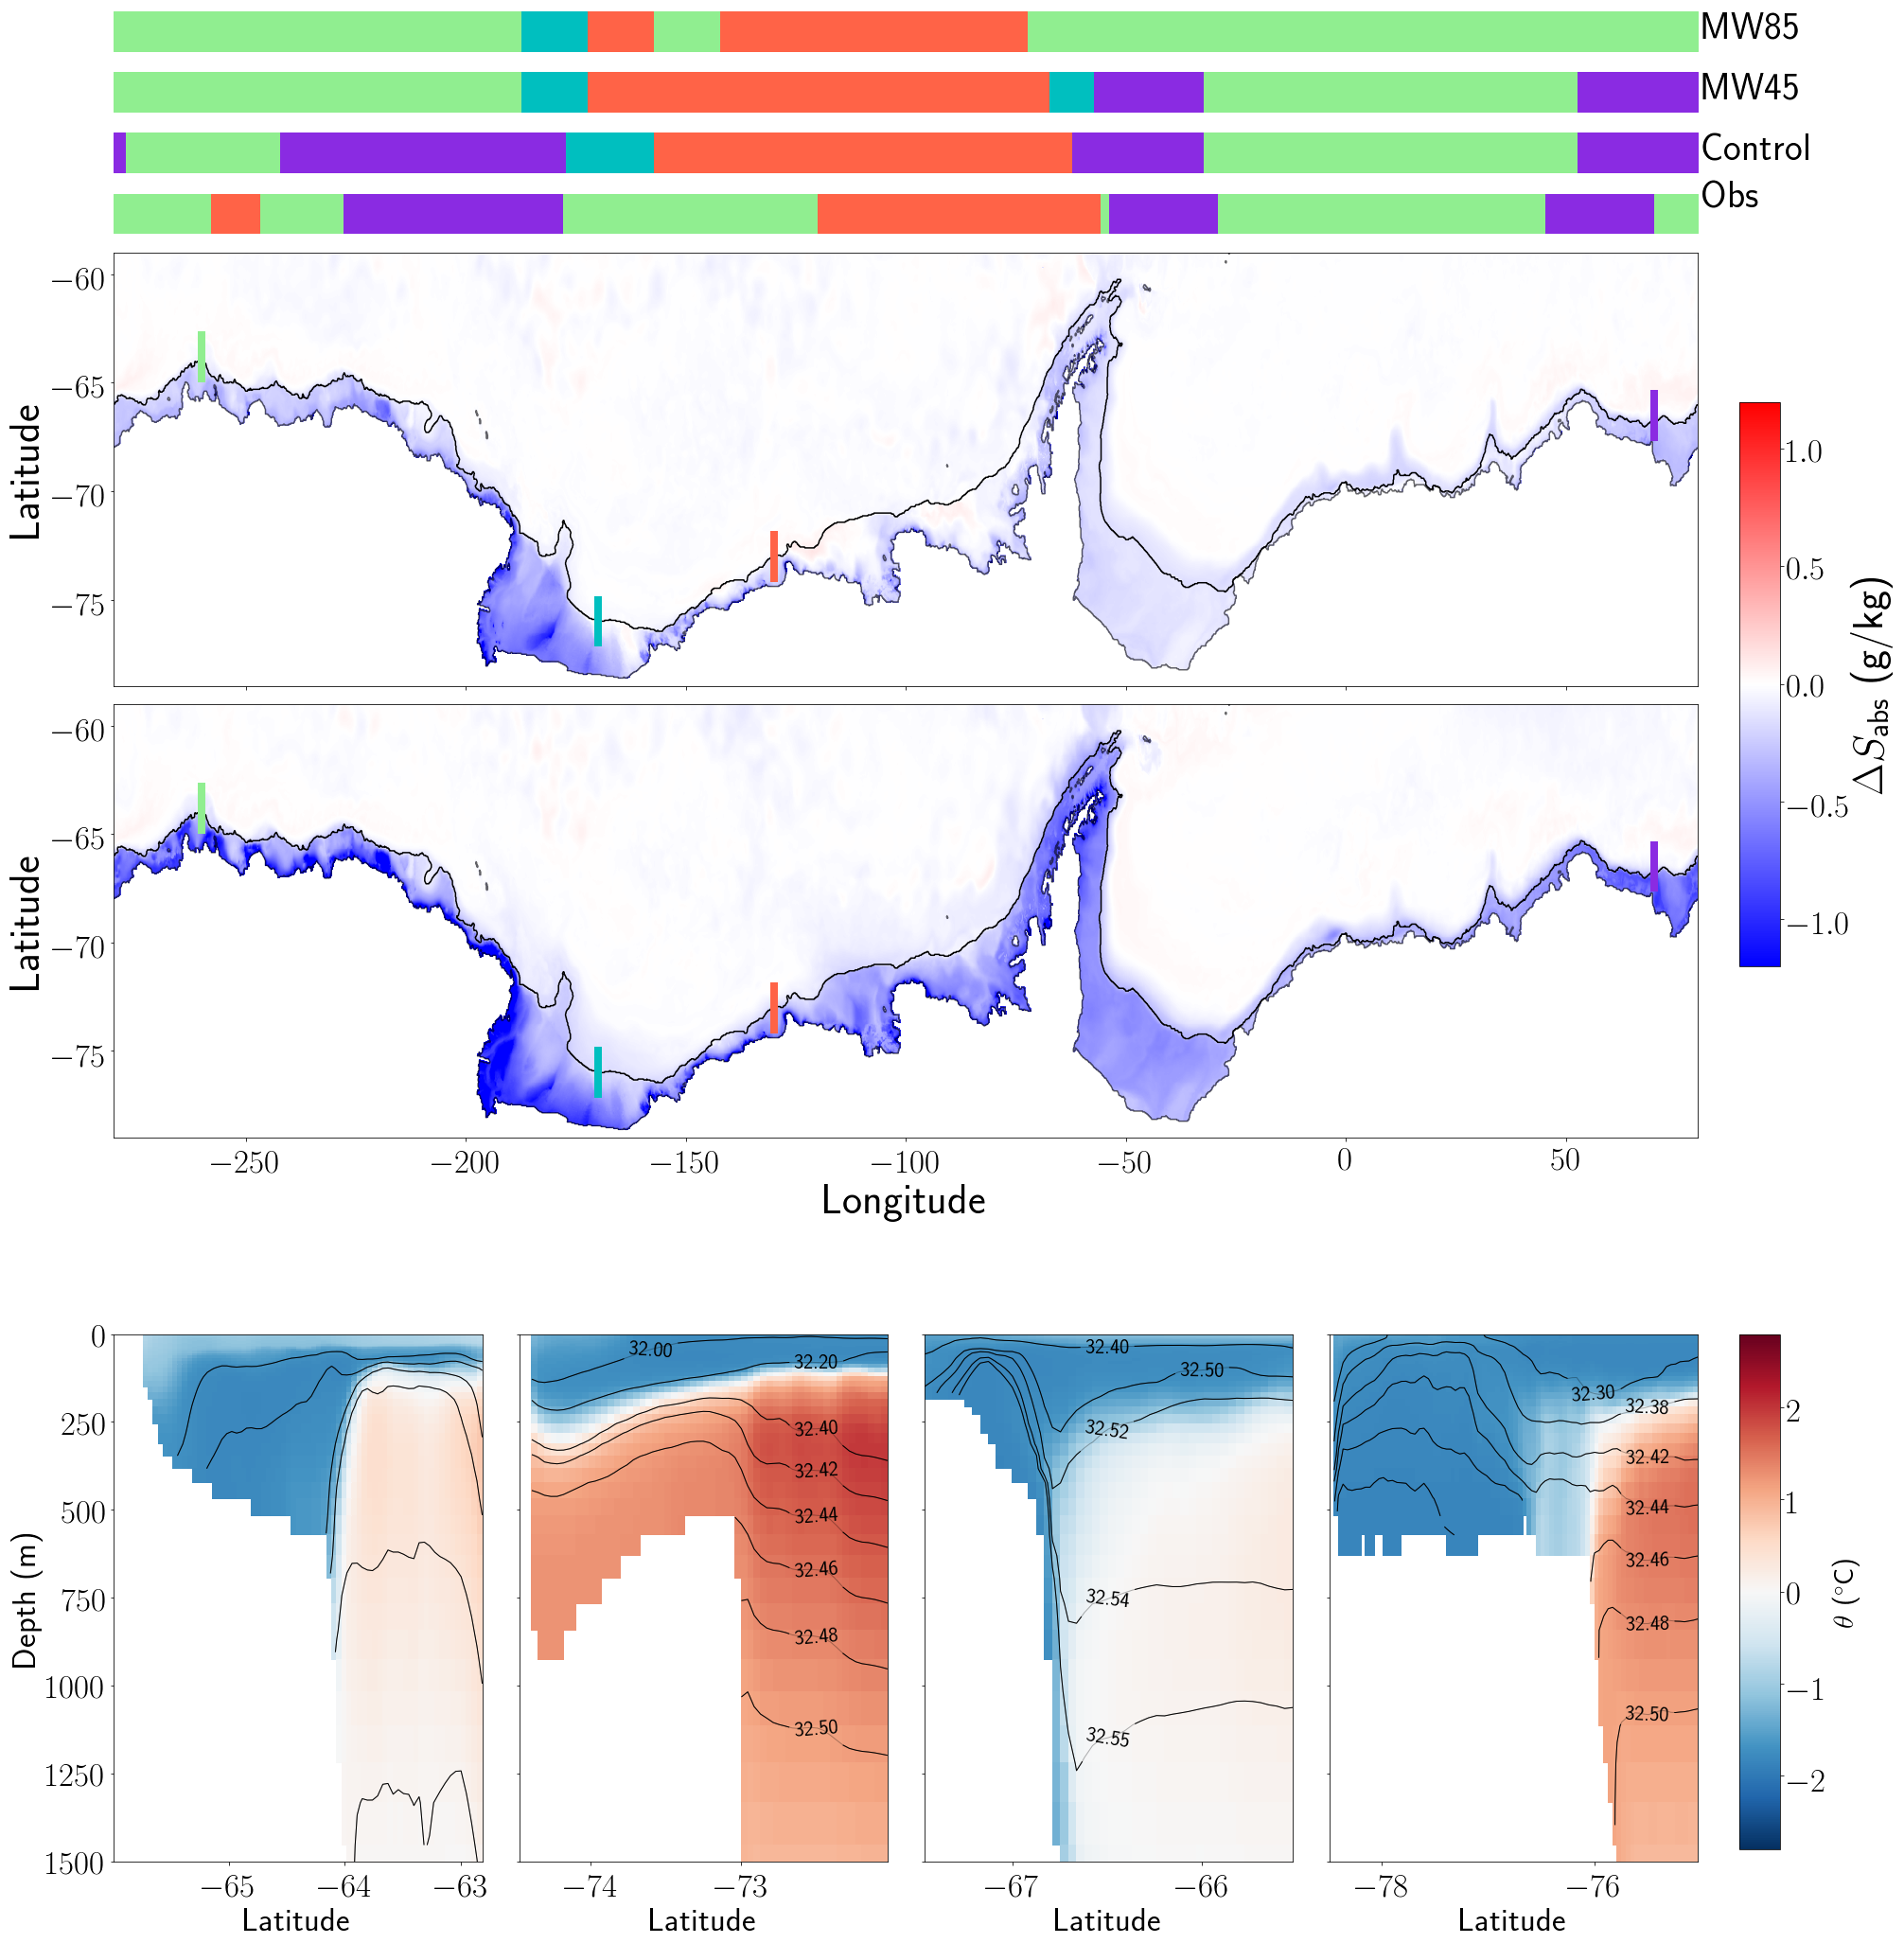

In [21]:
fig=plt.figure(1,(30,36))
gs1 = gridspec.GridSpec(6, 1, height_ratios=[1, 1, 1, 1, 10,10]) 
gs1.update(bottom = 0.42)

ax = plt.subplot(gs1[5])
ax0 = plt.subplot(gs1[4])
ax1 = plt.subplot(gs1[3], sharex = ax0)
ax2 = plt.subplot(gs1[2], sharex = ax0)
ax3 = plt.subplot(gs1[1], sharex = ax0)
ax4 = plt.subplot(gs1[0], sharex = ax0)

salt = salinity_maps(ax0, ax)
ASC_strips(ax1, ax2, ax3, ax4)

gs2 = gridspec.GridSpec(1, 4) 
gs2.update(top = 0.34, wspace = 0.1)

ax6 = plt.subplot(gs2[0])
ax7 = plt.subplot(gs2[1])
ax8 = plt.subplot(gs2[2])
ax9 = plt.subplot(gs2[3])

plot = fresh_example(ax6)
warm_example(ax7)
dense_example(ax8)
cool_example(ax9)

cax = plt.axes([0.92, 0.13, 0.02, 0.21])
cbar=fig.colorbar(plot, cax = cax ,orientation='vertical')
cbar.set_label(r'$\theta$ ($^\circ$C)', fontsize = 30)

cax = plt.axes([0.92, 0.49, 0.02, 0.23])
cbar=fig.colorbar(salt, cax = cax ,orientation='vertical', ticks = [-1.5,-1,-0.5,0,0.5, 1, 1.5])
cbar.set_label(r'$\Delta S_{\text{abs}}$ (g/kg)', fontsize = 45)

figurepath = 'Fig4.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)
plt.show()

Then I did some aestheric changes and added colored boxes for the identification of the shelf regimes offline in photoshop.

### cross-1000 m isobath temp/density plots.

Here I provide the procedure of how I generated all the cross isobath plots used to visually categorise stretches of shelf break into different categories. Below I use the final year of the MW85 experiment as an example, but the same transects and general idea were used for all experiments (I checked initial, year 5 and year 10 for all but only show year 10 above).

**Vertical & horizontal transects**

In [22]:
transect_lons = [75,75,70,70,65,65,60,60,55,55,51,51,45,45,40,40,35,35,30,30,25,25,15,15,10,10,5,5,-5,-5,-10,-10,-15,-15,-22.5,-22.5,-30,-30,-35,-35,-40,-40,-45,-45,-50,-50,-85,-85,-90,-90,-95,-95,-100,-100,-105,-105,-110,-110,-115,-115,-120,-120,-125,-125,-130,-130,-135,-135,-140,-140,-145,-145,-150,-150,-155,-155,-160,-160,-165,-165, -170,-170,-175,-175,-180,-180,-185,-185,-190,-190,-195,-195,-200,-200,-205,-205,-210,-210,-215,-215,-220,-220,-225,-225,-230,-230,-235,-235,-240,-240,-245,-245,-250,-250,-255,-255,-260,-260,-265,-265,-270,-270,-275,-275,-279.8,-279.8,-54,-48,-58,-52,-58,-52]
transect_lats = [-67.5,-65.5,-67.5,-65.5,-67.5,-65.5,-67.5,-65.5,-66,-64,-66.5,-64.55,-68,-66,-69,-67,-69,-67,-69.5,-67.5,-70.5,-68.5,-70,-68,-70.5,-68.5,-70.5,-68.5,-71,-69,-71.5,-69.5,-72.5,-70.5,-74.5,-72.5,-75,-73,-75,-73,-74.5,-72.5,-73.5,-71.5,-73,-71,-73.5,-69,-73,-69.5, -72.5,-69.5,-72,-69.5,-75,-70,-74.5,-70,-74,-70.5,-74,-71,-74,-71,-74.5,-72,-75,-72.5,-75.5,-73,-75.5,-73.5,-77,-74.5,-77.5,-75,-78.2,-75,-78.7,-75,-78.5,-75,-78.5,-74, -74.5,-71.5,-74,-71,-71.7,-69.5,-70.8,-68.5,-70.5,-68,-69,-65.5,-68.5,-64.5,-67.3,-64.5,-66.8,-64.5,-66.5,-63.5,-66.5,-63.5,-67,-64,-67,-64,-66.7,-64,-67,-64,-66.5,-63.5,-66,-62.8,-66.5,-63.5,-67,-64.5,-66.8,-64.5,-68,-64.5,-63.5,-63.5,-67,-67,-70,-70]

In [47]:
rc('text', usetex=True)
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20) 

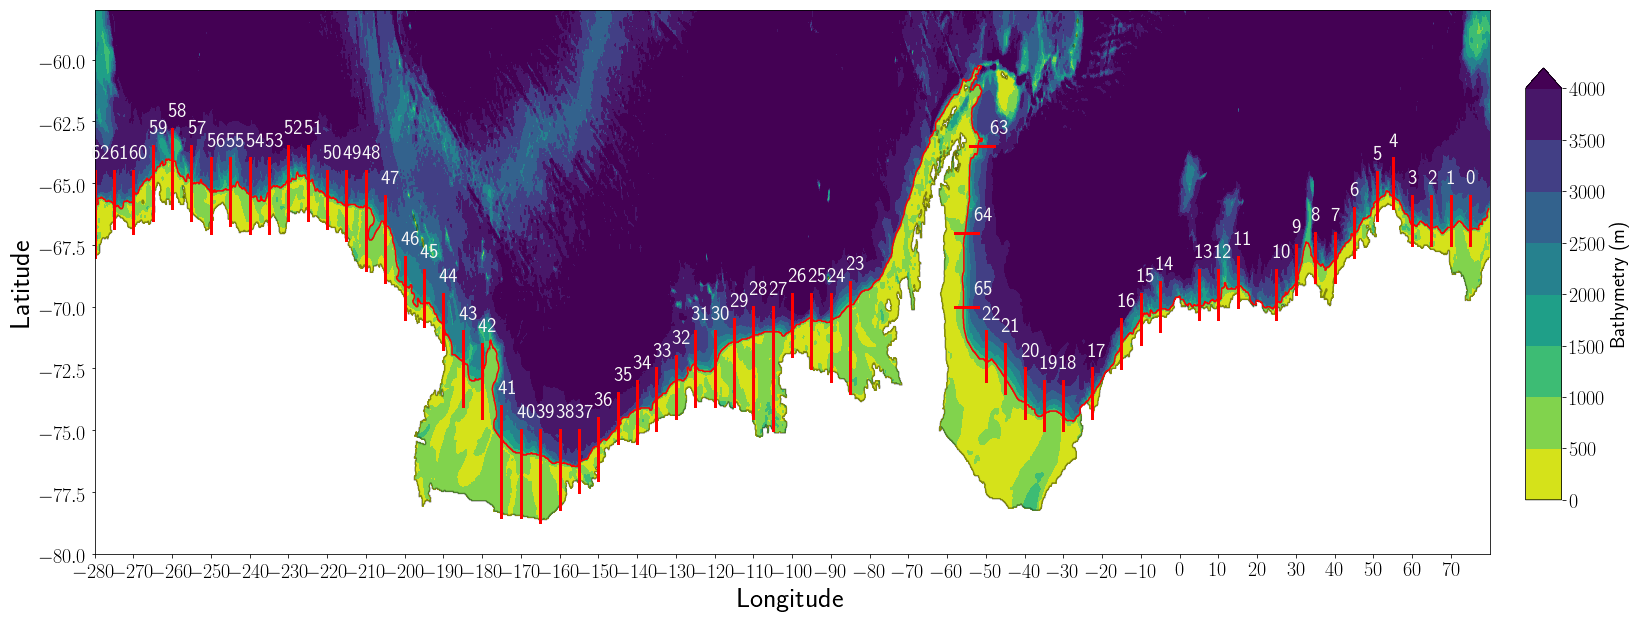

In [48]:
fig=plt.figure(2,(25,10))
ax0 = plt.subplot()
ht_plot = ht.sel(yt_ocean = slice(-80,-55)).sel(xt_ocean = slice(-280,80))
levels=[0,500,1000,1500, 2000, 2500, 3000,3500,4000]
norm1 = col.Normalize(vmin=0,vmax=4000)    
plot = ax0.contourf(ht_plot.xt_ocean,ht_plot.yt_ocean,np.squeeze(ht_plot.values),levels=levels,cmap='viridis_r',norm=norm1,extend='max')
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label(r'Bathymetry (m)')
land_mask = land_mask.astype(int)
levels = np.linspace(np.min(land_mask), np.max(land_mask), 2)
ax0.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.4)
ax0.contour(ht_shelf.xt_ocean, ht_shelf.yt_ocean, shelf_mask.values, [0,1], colors = 'r', linewidth = 2)
for i in range(66):
    ax0.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'red', linewidth = 3)
    ax0.text(transect_lons[2*i+1]-1, transect_lats[2*i+1]+0.5, '$\mathsf{'+str(i)+'}$', fontsize = 20, color = 'whitesmoke')
ax0.set_xlim((-280,80))
ax0.set_ylim((-80,-58))
ax0.set_ylabel('Latitude', fontsize = 28)
ax0.set_xlabel('Longitude', fontsize = 28)
ax0.set_xticks(np.arange(-280,80,10))
plt.show()

In [35]:
temp = cc.querying.getvar(rcp85,'temp', session, ncfile = 'ocean.nc', start_time = '1946-06', end_time = '1947-06')
salt = cc.querying.getvar(rcp85,'salt', session, ncfile = 'ocean.nc', start_time = '1946-06', end_time = '1947-06')
latslice = slice(-90,-59)
timeslice = slice('1946-06', '1947-05')
temp = temp.sel(time = timeslice, yt_ocean = latslice) - 273.15
salt = salt.sel(time = timeslice, yt_ocean = latslice)

In [38]:
time = temp.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
weights = weights.chunk({'time':1})

In [39]:
%%time
## now I want to loop through and compute the potential temperature and potential denisty profile for each
## cant do in a single array since the transects will be on slightly different dimensions
for i in range(63): # leaving off the last three for now as they are zonal transects
    filename = '/g/data/v45/rm2389/ASC_Transects/MW85_example/temp_'+str(i)+'.nc'
    lon = transect_lons[2*i] ## note theis loop will not do the horizontal transects correctly
    lat1 = transect_lats[2*i]
    lat2 = transect_lats[2*i+1]
    temp_transect = temp.sel(xt_ocean = lon, method = 'nearest').sel(yt_ocean = slice(lat1,lat2)) 
    temp_transect = (temp_transect*weights).mean(dim = 'time')
    temp_transect = temp_transect.load()
    temp_transect.attrs['longitude'] = lon
    temp_transect.attrs['units'] = 'C'
    ds = xr.Dataset({'pot_temp_transect': temp_transect})
    ds.to_netcdf(filename)

CPU times: user 16 s, sys: 1.22 s, total: 17.2 s
Wall time: 2min 54s


In [43]:
%%time
## do the constant latitude transects
for i in range(63,66):
    filename = '/g/data/v45/rm2389/ASC_Transects/MW85_example/temp_'+str(i)+'.nc'
    lat = transect_lats[2*i]
    lon1 = transect_lons[2*i]
    lon2 = transect_lons[2*i+1]
    temp_transect = temp.sel(xt_ocean = slice(lon1,lon2)).sel(yt_ocean = lat, method = 'nearest') 
    temp_transect = (temp_transect*weights).mean(dim = 'time')
    temp_transect = temp_transect.load()
    temp_transect.attrs['units'] = 'C'
    ds = xr.Dataset({'pot_temp_transect': temp_transect})
    ds.to_netcdf(filename)

CPU times: user 685 ms, sys: 48 ms, total: 733 ms
Wall time: 8.06 s


In [44]:
%%time
st_ocean = temp.st_ocean.values
time = temp.time.values
depth = -st_ocean
depth = xr.DataArray(depth, coords = [st_ocean], dims = ['st_ocean'])

## computing pot_rho_1 is more involved and time consuming than extracting the density profiles computed online
for i in range(63):
    filename = '/g/data/v45/rm2389/ASC_Transects/MW85_example/sigma1_'+str(i)+'.nc'
    lon = transect_lons[2*i] ## note theis loop will not do the horizontal transects correctly
    lat1 = transect_lats[2*i]
    lat2 = transect_lats[2*i+1]
    ## need sliced temp and salt
    temp_transect = temp.sel(xt_ocean = lon, method = 'nearest').sel(yt_ocean = slice(lat1,lat2)) 
    salt_transect = salt.sel(xt_ocean = lon, method = 'nearest').sel(yt_ocean = slice(lat1,lat2))
    yt_transect = temp_transect.yt_ocean.values
    ## compute a depth array of the transect dimensions
    depth_transect = (temp_transect.isel(time = 0)*0+1) * depth
    ## compute pressure
    pressure_transect = xr.DataArray(p_from_z(depth_transect,yt_transect), coords = [st_ocean, yt_transect], dims = ['st_ocean','yt_ocean'],  name = 'pressure', attrs = {'units':'dbar'})
    ## compute absolute salinity
    absolute_salt= xr.DataArray(SA_from_SP(salt_transect,pressure_transect,lon,yt_transect), coords = [time,st_ocean,yt_transect], dims = ['time','st_ocean','yt_ocean'], name = 'Absolute salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    ## compute conservative temperature
    conservative_temp = xr.DataArray(CT_from_pt(absolute_salt,temp_transect), coords = [time,st_ocean,yt_transect], dims = ['time','st_ocean','yt_ocean'], name = 'Conservative temperature', attrs = {'units':'Conservative Temperature (C)'})
    ## compute sigma1
    pot_rho_1 = xr.DataArray(sigma1(absolute_salt, conservative_temp),coords = [time,st_ocean, yt_transect], dims = ['time','st_ocean', 'yt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    pot_rho_1 = (pot_rho_1*weights).mean(dim = 'time')
    ds = xr.Dataset({'pot_rho_1_transect': pot_rho_1})
    ds.to_netcdf(filename)
    del temp_transect, salt_transect, depth_transect, pressure_transect, absolute_salt, conservative_temp, pot_rho_1

CPU times: user 37.5 s, sys: 2.3 s, total: 39.8 s
Wall time: 4min 9s


In [45]:
%%time
for i in range(63,66):
    filename = '/g/data/v45/rm2389/ASC_Transects/MW85_example/sigma1_'+str(i)+'.nc'
    lat = transect_lats[2*i]
    lon1 = transect_lons[2*i]
    lon2 = transect_lons[2*i+1]
    ## need sliced temp and salt
    temp_transect = temp.sel(xt_ocean = slice(lon1,lon2)).sel(yt_ocean = lat, method = 'nearest') 
    salt_transect = salt.sel(xt_ocean = slice(lon1,lon2)).sel(yt_ocean = lat, method = 'nearest')
    xt_transect = temp_transect.xt_ocean.values
    ## compute a depth array of the transect dimensions
    depth_transect = (temp_transect.isel(time = 0)*0+1) * depth
    ## compute pressure
    pressure_transect = xr.DataArray(p_from_z(depth_transect,lat), coords = [st_ocean, xt_transect], dims = ['st_ocean','xt_ocean'],  name = 'pressure', attrs = {'units':'dbar'})
    ## compute absolute salinity
    absolute_salt= xr.DataArray(SA_from_SP(salt_transect,pressure_transect,xt_transect,lat), coords = [time,st_ocean,xt_transect], dims = ['time','st_ocean','xt_ocean'], name = 'Absolute salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    ## compute conservative temperature
    conservative_temp = xr.DataArray(CT_from_pt(absolute_salt,temp_transect), coords = [time,st_ocean,xt_transect], dims = ['time','st_ocean','xt_ocean'], name = 'Conservative temperature', attrs = {'units':'Conservative Temperature (C)'})
    ## compute sigma1
    pot_rho_1 = xr.DataArray(sigma1(absolute_salt, conservative_temp),coords = [time,st_ocean, xt_transect], dims = ['time','st_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    pot_rho_1 = (pot_rho_1*weights).mean(dim = 'time')
    ds = xr.Dataset({'pot_rho_1_transect': pot_rho_1})
    ds.to_netcdf(filename)
    del temp_transect, salt_transect, depth_transect, pressure_transect, absolute_salt, conservative_temp, pot_rho_1

CPU times: user 1.68 s, sys: 95 ms, total: 1.78 s
Wall time: 11.8 s


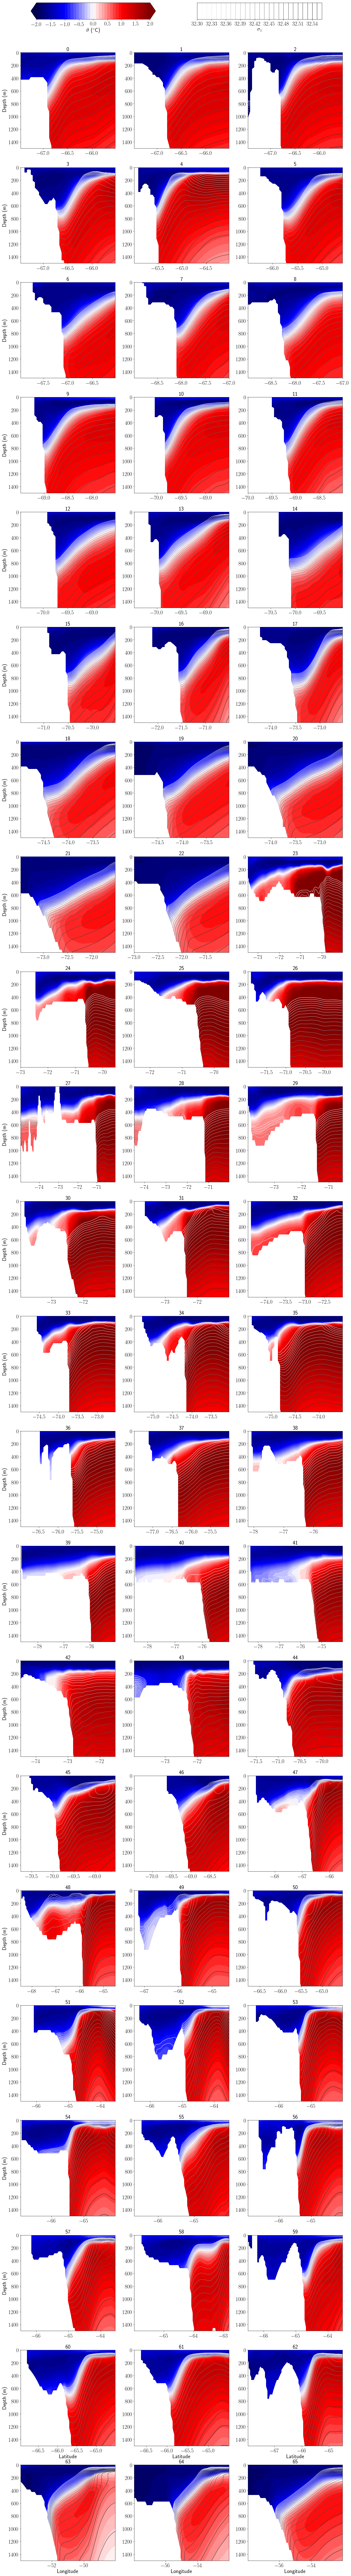

In [49]:
fig, axs  = plt.subplots(22,3,sharey = 'col', figsize = (21,168))
gs = gridspec.GridSpec(22,3)
axs[0,0], axs[0,1], axs[0,2],axs[1,0], axs[1,1], axs[1,2], axs[2,0], axs[2,1], axs[2,2], axs[3,0], axs[3,1], axs[3,2], axs[4,0], axs[4,1], axs[4,2], axs[5,0], axs[5,1], axs[5,2], axs[6,0], axs[6,1], axs[6,2], axs[7,0], axs[7,1], axs[7,2], axs[8,0], axs[8,1], axs[8,2], axs[9,0], axs[9,1], axs[9,2], axs[10,0], axs[10,1], axs[10,2], axs[11,0], axs[11,1], axs[11,2], axs[12,0], axs[12,1], axs[12,2], axs[13,0], axs[13,1], axs[13,2], axs[14,0], axs[14,1], axs[14,2], axs[15,0], axs[15,1], axs[15,2], axs[16,0], axs[16,1], axs[16,2], axs[17,0], axs[17,1], axs[17,2], axs[18,0], axs[18,1], axs[18,2], axs[19,0], axs[19,1], axs[19,2], axs[20,0], axs[20,1], axs[20,2], axs[21,0], axs[21,1], axs[21,2], = plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[0, 2]), plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[1, 2]), plt.subplot(gs[2, 0]), plt.subplot(gs[2, 1]), plt.subplot(gs[2, 2]),plt.subplot(gs[3, 0]), plt.subplot(gs[3, 1]), plt.subplot(gs[3, 2]), plt.subplot(gs[4, 0]), plt.subplot(gs[4, 1]), plt.subplot(gs[4, 2]), plt.subplot(gs[5, 0]), plt.subplot(gs[5, 1]), plt.subplot(gs[5, 2]),plt.subplot(gs[6, 0]), plt.subplot(gs[6, 1]), plt.subplot(gs[6, 2]), plt.subplot(gs[7, 0]), plt.subplot(gs[7, 1]), plt.subplot(gs[7, 2]), plt.subplot(gs[8, 0]), plt.subplot(gs[8, 1]), plt.subplot(gs[8, 2]),plt.subplot(gs[9, 0]), plt.subplot(gs[9, 1]), plt.subplot(gs[9, 2]),plt.subplot(gs[10, 0]), plt.subplot(gs[10, 1]), plt.subplot(gs[10, 2]),plt.subplot(gs[11, 0]), plt.subplot(gs[11, 1]), plt.subplot(gs[11, 2]),plt.subplot(gs[12, 0]), plt.subplot(gs[12, 1]), plt.subplot(gs[12, 2]),plt.subplot(gs[13, 0]),plt.subplot(gs[13, 1]), plt.subplot(gs[13, 2]),plt.subplot(gs[14, 0]), plt.subplot(gs[14, 1]), plt.subplot(gs[14, 2]),plt.subplot(gs[15, 0]), plt.subplot(gs[15, 1]), plt.subplot(gs[15, 2]), plt.subplot(gs[16, 0]), plt.subplot(gs[16, 1]), plt.subplot(gs[16, 2]), plt.subplot(gs[17, 0]), plt.subplot(gs[17, 1]), plt.subplot(gs[17, 2]),plt.subplot(gs[18, 0]), plt.subplot(gs[18, 1]), plt.subplot(gs[18, 2]), plt.subplot(gs[19, 0]), plt.subplot(gs[19, 1]), plt.subplot(gs[19, 2]), plt.subplot(gs[20, 0]), plt.subplot(gs[20, 1]), plt.subplot(gs[20, 2]),plt.subplot(gs[21, 0]), plt.subplot(gs[21, 1]), plt.subplot(gs[21, 2])

ax = (0,0,0,1,0,2,1,0,1,1,1,2,2,0,2,1,2,2,3,0,3,1,3,2,4,0,4,1,4,2,5,0,5,1,5,2,6,0,6,1,6,2,7,0,7,1,7,2,8,0,8,1,8,2,9,0,9,1,9,2,10,0,10,1,10,2,11,0,11,1,11,2,12,0,12,1,12,2,13,0,13,1,13,2,14,0,14,1,14,2,15,0,15,1,15,2,16,0,16,1,16,2,17,0,17,1,17,2,18,0,18,1,18,2,19,0,19,1,19,2,20,0,20,1,20,2,21,0,21,1,21,2,22,0,22,1,22,2)

levels = np.arange(-2,2.1,0.1)
norm1 = col.Normalize(vmin=-2,vmax=2) 

for i in range(21):
    axs[ax[2*(3*i)],ax[2*(3*i)+1]].set_ylabel('Depth (m)')

axs[ax[2*63],ax[2*63+1]].set_xlabel('Longitude')
axs[ax[2*64],ax[2*64+1]].set_xlabel('Longitude')
axs[ax[2*65],ax[2*65+1]].set_xlabel('Longitude')
axs[ax[2*60],ax[2*63+1]].set_xlabel('Latitude')
axs[ax[2*61],ax[2*64+1]].set_xlabel('Latitude')
axs[ax[2*62],ax[2*65+1]].set_xlabel('Latitude')

## temperature shading
for i in range(63):
    filename = '/g/data/v45/rm2389/ASC_Transects/MW85_example/temp_'+str(i)+'.nc'
    temp_transect = xr.open_dataset(filename)
    temp_transect = temp_transect.pot_temp_transect
    plot = axs[ax[2*i],ax[2*i+1]].contourf(temp_transect.yt_ocean,temp_transect.st_ocean,temp_transect.values,levels=levels,cmap='seismic',norm=norm1,extend='both')
    axs[ax[2*i],ax[2*i+1]].set_title(str(i), fontsize = 20)
for i in range (63, 66):
    filename = '/g/data/v45/rm2389/ASC_Transects/MW85_example/temp_'+str(i)+'.nc'
    temp_transect = xr.open_dataset(filename)
    temp_transect = temp_transect.pot_temp_transect
    plot = axs[ax[2*i],ax[2*i+1]].contourf(temp_transect.xt_ocean,temp_transect.st_ocean,temp_transect.values,levels=levels,cmap='seismic',norm=norm1,extend='both')
    axs[ax[2*i],ax[2*i+1]].set_title(str(i), fontsize = 20)

    
levels = np.arange(32.3,32.6,0.01)
## potential density contours
for i in range(63):
    filename = '/g/data/v45/rm2389/ASC_Transects/MW85_example/sigma1_'+str(i)+'.nc'
    pot_rho_transect = xr.open_dataset(filename)
    pot_rho_transect = pot_rho_transect.pot_rho_1_transect
    contours = axs[ax[2*i],ax[2*i+1]].contour(pot_rho_transect.yt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, cmap = 'binary', linewidths=1)
    axs[ax[2*i],ax[2*i+1]].set_ylim(1500,0)
for i in range(63,66):
    filename = '/g/data/v45/rm2389/ASC_Transects/MW85_example/sigma1_'+str(i)+'.nc'
    pot_rho_transect = xr.open_dataset(filename)
    pot_rho_transect = pot_rho_transect.pot_rho_1_transect
    contours = axs[ax[2*i],ax[2*i+1]].contour(pot_rho_transect.xt_ocean, pot_rho_transect.st_ocean, pot_rho_transect.values, levels=levels, cmap = 'binary', linewidths=1)
    axs[ax[2*i],ax[2*i+1]].set_ylim(1500,0)
    
cax = fig.add_axes([0.15, 0.89, 0.3, 0.005])
cbar=plt.colorbar(plot, cax = cax,orientation='horizontal', shrink = 0.5)
cbar.set_label(r'$\theta$ ($^\circ$C)')

cax = fig.add_axes([0.55, 0.89, 0.3, 0.005])
cbar=plt.colorbar(contours, cax = cax,orientation='horizontal', shrink = 0.5)
cbar.set_label(r'$\sigma_1$')


plt.show()

I also made some more irregular transects around the West Antarctic Peninsula, but I won't repeat that here as the xarray functions used are outdated. But the basic procedure was:

```
names = ['wap_1', 'wap_6', 'wap_7', 'wap_2', 'wap_3', 'wap_4', 'wap_5', 'wap_8']
lons = [-80,-82,-61.25,-65.75,-56.5,-59,-79,-74,-77,-71,-74,-68.5,-70,-65,-55,-48]
lats = [-70,-68,-63.25,-61, -62,-60,-67.5,-69,-66.25,-67.75,-65,-66.5,-63,-64.5,-62.5,-62.75]

mean_temp = (temp*weights).mean(dim = 'time')
mean_salt = (salt*weights).mean(dim = 'time')

for i in range(8:
    filename = '/g/data/v45/rm2389/ASC_Transects/control/temp_transect_'+names[i]+'.nc'
    lat1 = lats[2*i]
    lat2 = lats[2*i+1]
    lon1 = lons[2*i]
    lon2 = lons[2*i+1]

    if i < 3:
        lat_array = yt_ocean.sel(yt_ocean = slice(lat1,lat2)).values
        slope = (lon1 - lon2)/(lat1-lat2)
        intercept = lon1 - slope * lat1
        lon_array_perf = slope * lat_array + intercept
        temp_transect = mean_temp.sel_points(xt_ocean = lon_array_perf, yt_ocean = lat_array, method = 'nearest')
        temp_transect = temp_transect.load()
        ds = xr.Dataset({'pot_temp_transect': temp_transect})
        ds.to_netcdf(filename)  
        
    if i >= 3:
        lon_array = xt_ocean.sel(xt_ocean = slice(lon1,lon2)).values
        slope = (lat1 - lat2)/(lon1-lon2)
        intercept = lat1 - slope * lon1
        lat_array_perf = slope * lon_array + intercept
        temp_transect = mean_temp.sel_points(yt_ocean = lat_array_perf, xt_ocean = lon_array, method = 'nearest')
        temp_transect = temp_transect.load()
        ds = xr.Dataset({'pot_temp_transect': temp_transect})
        ds.to_netcdf(filename) 
        
```
But I would need to use something other than sel_points (I think I can just use sel or some interpolation thing) if I want to do something like this using latest xarray release.